In [1]:
#구글 코랩 파일 직접 로딩하기
from google.colab import files
myfile=files.upload()
myfile1=files.upload()

Saving train_trans.csv to train_trans.csv


Saving test_trans.csv to test_trans.csv


In [2]:
import io
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

import missingno as msno
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus']=False

%matplotlib inline

In [4]:
# 1) PART1 = Data Import & Data Check
df_train=pd.read_csv(io.BytesIO(myfile['train_trans.csv']))
df_test=pd.read_csv(io.BytesIO(myfile1['test_trans.csv']))

In [5]:
df_train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [6]:
#train 데이터 확인
#11개의 feature들이 정수와 실수 데이터들로 구성
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [7]:
#결측치 확인
for col in df_train.columns: 
  msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0])) 
  print(msperc)

column:         id	 Percent of NaN value: 0.00%
column:       hour	 Percent of NaN value: 0.00%
column: hour_bef_temperature	 Percent of NaN value: 0.14%
column: hour_bef_precipitation	 Percent of NaN value: 0.14%
column: hour_bef_windspeed	 Percent of NaN value: 0.62%
column: hour_bef_humidity	 Percent of NaN value: 0.14%
column: hour_bef_visibility	 Percent of NaN value: 0.14%
column: hour_bef_ozone	 Percent of NaN value: 5.21%
column: hour_bef_pm10	 Percent of NaN value: 6.17%
column: hour_bef_pm2.5	 Percent of NaN value: 8.02%
column:      count	 Percent of NaN value: 0.00%


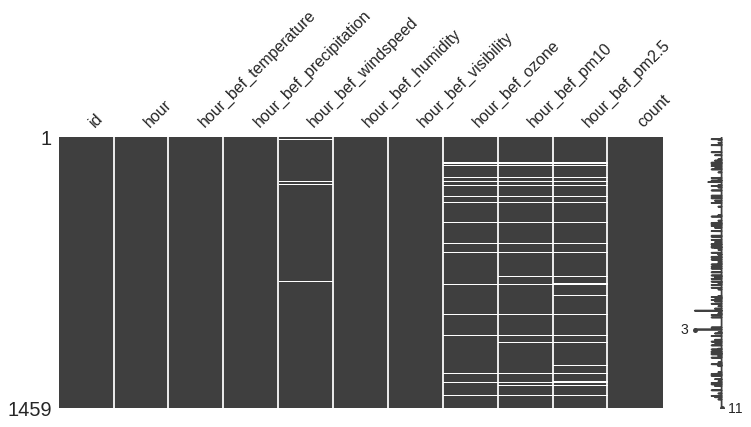

In [8]:
#결측치 시각화
#hour_bef_ozone, hour_bef_pm10, hour_bef_pm2.5 결측치 확인
msno.matrix(df_train, figsize=(12,5))

Skewness: 0.912534
Kurtosis: 0.460328


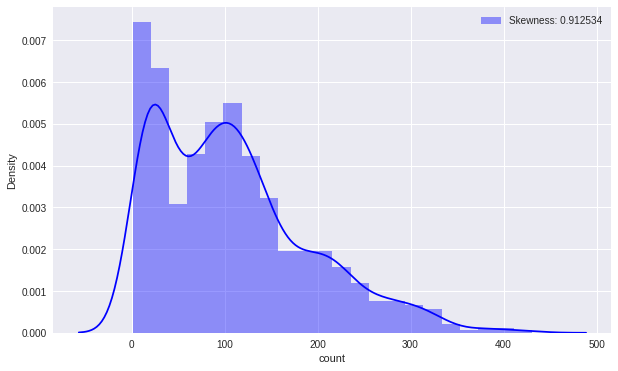

In [9]:
#target 변수인 count의 왜도와 첨도 확인
#Skewness(비대칭도)는 분포가 어느정도의 비대칭을 가지고있는지 알려주는 지표
#Kurtosis(첨도)는 확률분포의 뾰족한 정도를 알려주는 지표
#count의 대부분의 데이터가 0에 몰려있는 모습 확인
f, ax=plt.subplots(1,1,figsize=(10,6))
g=sns.distplot(df_train["count"],color="b",label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax)
g=g.legend(loc="best")

print("Skewness: %f" % df_train["count"].skew()) 
print("Kurtosis: %f" % df_train["count"].kurt())

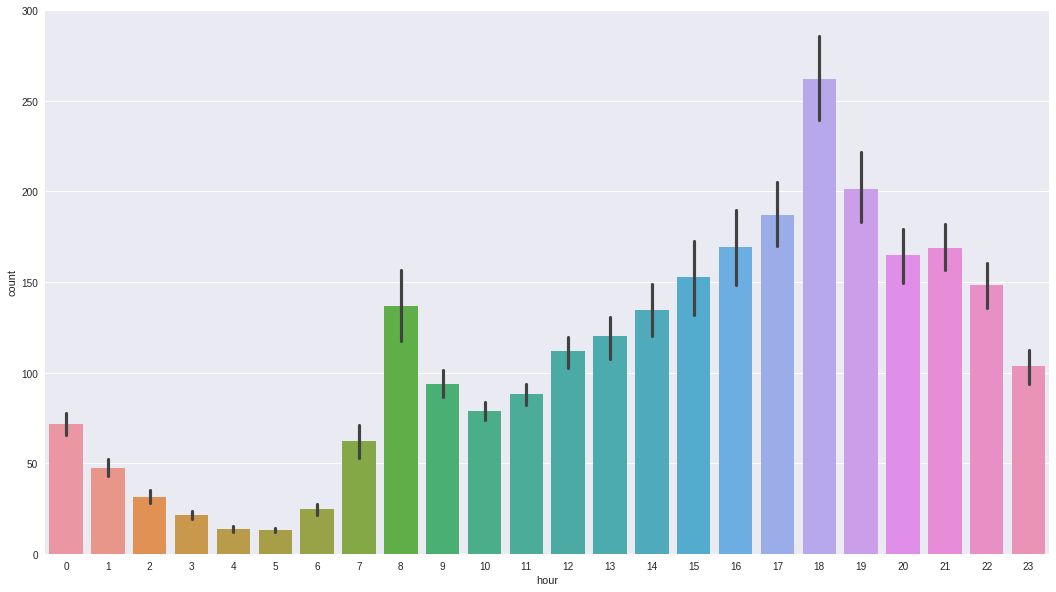

In [10]:
# 2) PART2 = EDA(데이터 시각화)
# 대여량 직관적 파악 위해 barplot을 사용해 시각화
# 시간별 대여량은 오후 15시 ~ 22시 가량이 높음, 출퇴근시간 고려
figure, ax1=plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(18,10)

sns.barplot(data=df_train, x="hour",y="count",ax=ax1)

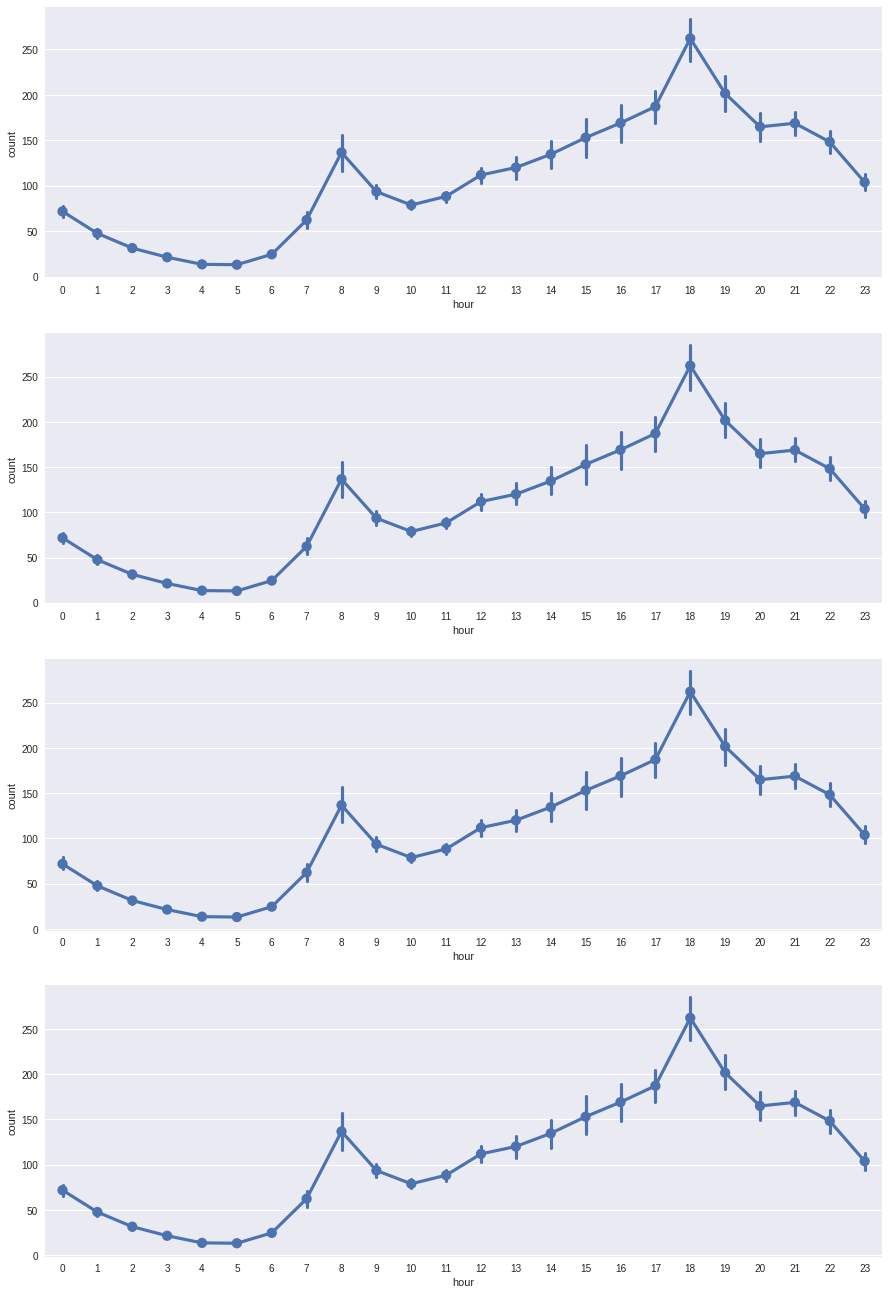

In [11]:
#시간의 흐름에 따른 pointplot 시각화
fig, (ax1,ax2,ax3,ax4)=plt.subplots(nrows=4)
fig.set_size_inches(15,23)

sns.pointplot(data=df_train, x="hour",y="count",ax=ax1)
sns.pointplot(data=df_train, x="hour",y="count",z="hour_bef_temperature",ax=ax2)
sns.pointplot(data=df_train, x="hour",y="count",z="hour_bef_precipitation",ax=ax3)
sns.pointplot(data=df_train, x="hour",y="count",z="hour_bef_windspeed",ax=ax4)

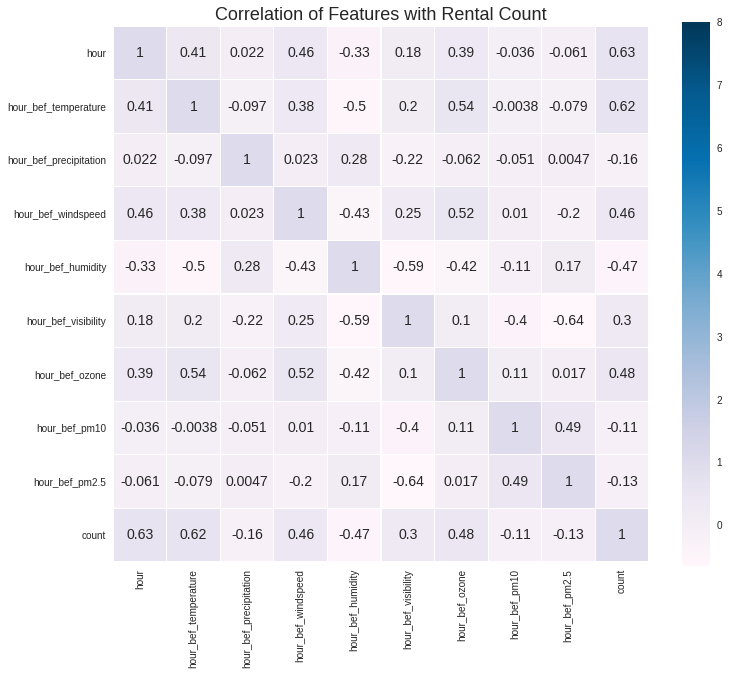

In [12]:
#feature 상관관계 시각화
#시간,온도 상관관계 확인
corr_data=df_train[['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count']]
colormap=plt.cm.PuBu

f, ax=plt.subplots(figsize=(12,10))
plt.title('Correlation of Features with Rental Count',y=1,size=18)
sns.heatmap(corr_data.corr(),vmax=8,linewidths=0.1,square=True,annot=True,cmap=colormap, linecolor="white",annot_kws = {'size':14})


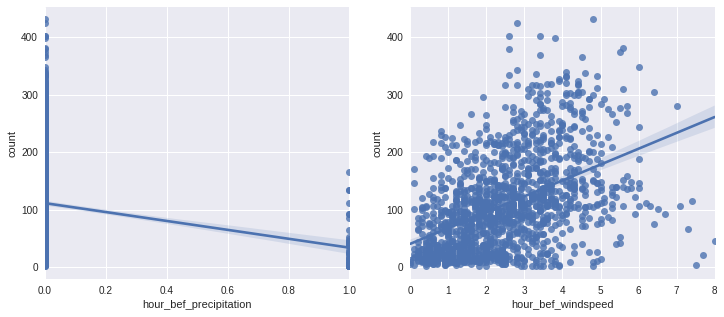

In [13]:
#heatmap을 통해 무의미하다고 판단된 feature에 대해 Scatterplot 시각화
#강수량의 경우 대부분의 데이터가 0에 분포 --> 강수량이 0인 경우가 드물기 때문에 null데이터를 0으로 대체한게 아닌가 추측
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(12,5)) 

temp_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_precipitation']],axis = 1) 
sns.regplot(x='hour_bef_precipitation',y = 'count',data = temp_scatter_plot,scatter= True, fit_reg=True, ax=ax1) 
windspeed_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_windspeed']],axis = 1) 
sns.regplot(x='hour_bef_windspeed',y = 'count',data = windspeed_scatter_plot,scatter= True, fit_reg=True, ax=ax2)

In [14]:
# 결측치 처리
# 결측치 여부 확인
df_train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [15]:
df_train['hour_bef_temperature'] = df_train['hour_bef_temperature'].fillna(value = df_train['hour_bef_temperature'].mean())

In [16]:
#결측치 확인
df_train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [17]:
train_isna_sum = df_train.isna().sum()

In [18]:
train_isna_sum[train_isna_sum != 0].index

Index(['hour_bef_precipitation', 'hour_bef_windspeed', 'hour_bef_humidity',
       'hour_bef_visibility', 'hour_bef_ozone', 'hour_bef_pm10',
       'hour_bef_pm2.5'],
      dtype='object')

In [19]:
na_columns = train_isna_sum[train_isna_sum != 0].index

In [20]:
def fill_bicycle_na(df, column) :
    
    df[column] = df[column].fillna(value = df[column].mean())

In [21]:
fill_bicycle_na(df_train, 'hour_bef_precipitation')

In [22]:
for col in na_columns:
    
    fill_bicycle_na(df_train, col)
    
    print(col, '결측값 대체 완료')

hour_bef_precipitation 결측값 대체 완료
hour_bef_windspeed 결측값 대체 완료
hour_bef_humidity 결측값 대체 완료
hour_bef_visibility 결측값 대체 완료
hour_bef_ozone 결측값 대체 완료
hour_bef_pm10 결측값 대체 완료
hour_bef_pm2.5 결측값 대체 완료


In [24]:
test_isna_sum = df_test.isna().sum()

In [25]:
test_na_columns = test_isna_sum[test_isna_sum != 0].index

In [26]:
for col in test_na_columns:
    print(col)

hour_bef_temperature
hour_bef_precipitation
hour_bef_windspeed
hour_bef_humidity
hour_bef_visibility
hour_bef_ozone
hour_bef_pm10
hour_bef_pm2.5


In [28]:
for col in test_na_columns:
    fill_bicycle_na(df_test, col)
    print(col, '대체 완료')

hour_bef_temperature 대체 완료
hour_bef_precipitation 대체 완료
hour_bef_windspeed 대체 완료
hour_bef_humidity 대체 완료
hour_bef_visibility 대체 완료
hour_bef_ozone 대체 완료
hour_bef_pm10 대체 완료
hour_bef_pm2.5 대체 완료


In [30]:
df_test.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

Skewness: 0.912534
Kurtosis: 0.460328


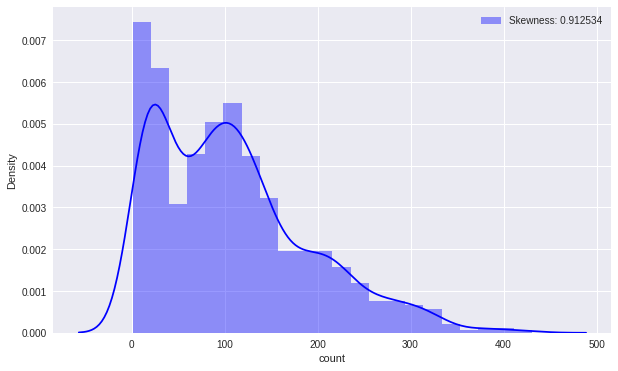

In [31]:
# 3) Part3 = Feature Engineering
# 튜닝하기 전에 레이블 클래스의 첨도와 왜도 확인 --> 데이터의 분포 확인
# 왜도 : 0을 기준 // 첨도 : 3을 기준 
# 모델에 사용되는 모든 변수들은 왜도와 첨도를 확인하는 것이 좋음
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count"], color = "b", label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax) 
g = g.legend(loc = "best") 

print("Skewness: %f" % df_train["count"].skew()) 
print("Kurtosis: %f" % df_train["count"].kurt())

Skewness: -1.014012
Kurtosis: 0.936030


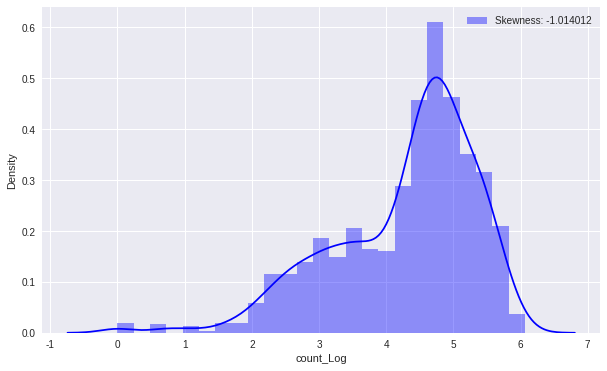

In [32]:
#로그정규분포 통해 target변수 튜닝
# why? 로그정규분포 변수는 항상 '양수'값 가짐 --> 정규분포가 음수값을 가지는 것에 대한 해결책이 될 수 있음
df_train["count_Log"] = df_train["count"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["count_Log"], color = "b", label="Skewness: {:2f}".format(df_train["count_Log"].skew()), ax=ax) 
g = g.legend(loc = "best") 

print("Skewness: %f" % df_train['count_Log'].skew()) 
print("Kurtosis: %f" % df_train['count_Log'].kurt()) 

df_train.drop('count', axis= 1, inplace=True)


In [33]:
# 4) Part4 = Modeling
# 학습을 위해 train_test_split을 통해 데이터 셋을 학습용과 검증용으로 구분
# 클래스 레이블인 count_Log를 제외한 나머지 feature들을 X_train에, count_Log의 값을 target_label에 저장
# X_tr, X_vld, y_tr, y_vld = 훈련 데이터, 테스트 데이터, 훈련 레이블, 테스트 레이블
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train=df_train.drop("count_Log",axis=1).values
target_label=df_train["count_Log"].values
X_test=df_test.values
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2000)

In [34]:
from sklearn.ensemble import GradientBoostingRegressor 
regressor = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05, 
                                      max_depth=4, min_samples_leaf=15, 
                                      min_samples_split=10, random_state =42) 

regressor.fit(X_tr,y_tr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

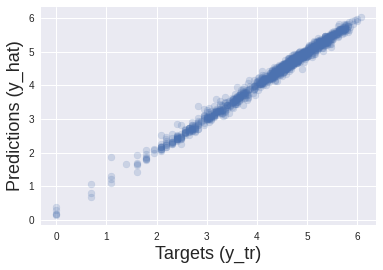

In [35]:
y_hat = regressor.predict(X_tr) 
plt.scatter(y_tr, y_hat, alpha = 0.2) 
plt.xlabel('Targets (y_tr)',size=18) 
plt.ylabel('Predictions (y_hat)',size=18) 
plt.show()

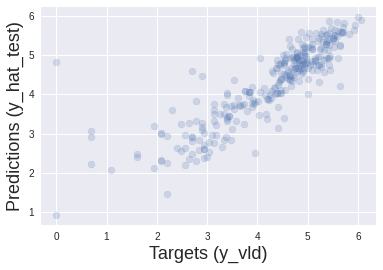

In [37]:
y_hat_test = regressor.predict(X_vld) 
plt.scatter(y_vld, y_hat_test, alpha=0.2) 
plt.xlabel('Targets (y_vld)',size=18) 
plt.ylabel('Predictions (y_hat_test)',size=18) 
plt.show()

In [52]:
from sklearn.model_selection import cross_val_score 
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 8)

In [53]:
print(accuracies.mean()) 
print(accuracies.std())

0.73551281966842
0.0781655403039464
